In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display, HTML
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from livelossplot import PlotLosses

# Fix the dying kernel problem (only a problem in some installations - you can remove it, if it works without it)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Load the dataset for recommenders

In [2]:
data_path = os.path.join("hotel_data", "hotel_data_interactions_df.csv")

interactions_df = pd.read_csv(data_path, index_col=0)

base_item_features = ['term', 'length_of_stay_bucket', 'rate_plan', 'room_segment', 'n_people_bucket', 'weekend_stay']

column_values_dict = {
    'term': ['WinterVacation', 'Easter', 'OffSeason', 'HighSeason', 'LowSeason', 'MayLongWeekend', 'NewYear', 'Christmas'],
    'length_of_stay_bucket': ['[0-1]', '[2-3]', '[4-7]', '[8-inf]'],
    'rate_plan': ['Standard', 'Nonref'],
    'room_segment': ['[0-160]', '[160-260]', '[260-360]', '[360-500]', '[500-900]'],
    'n_people_bucket': ['[1-1]', '[2-2]', '[3-4]', '[5-inf]'],
    'weekend_stay': ['True', 'False']
}

interactions_df.loc[:, 'term'] = pd.Categorical(
    interactions_df['term'], categories=column_values_dict['term'])
interactions_df.loc[:, 'length_of_stay_bucket'] = pd.Categorical(
    interactions_df['length_of_stay_bucket'], categories=column_values_dict['length_of_stay_bucket'])
interactions_df.loc[:, 'rate_plan'] = pd.Categorical(
    interactions_df['rate_plan'], categories=column_values_dict['rate_plan'])
interactions_df.loc[:, 'room_segment'] = pd.Categorical(
    interactions_df['room_segment'], categories=column_values_dict['room_segment'])
interactions_df.loc[:, 'n_people_bucket'] = pd.Categorical(
    interactions_df['n_people_bucket'], categories=column_values_dict['n_people_bucket'])
interactions_df.loc[:, 'weekend_stay'] = interactions_df['weekend_stay'].astype('str')
interactions_df.loc[:, 'weekend_stay'] = pd.Categorical(
    interactions_df['weekend_stay'], categories=column_values_dict['weekend_stay'])

display(HTML(interactions_df.head(15).to_html()))

,user_id,item_id,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1,0,WinterVacation,[2-3],Standard,[260-360],[5-inf],True
1,2,1,WinterVacation,[2-3],Standard,[160-260],[3-4],True
2,3,2,WinterVacation,[2-3],Standard,[160-260],[2-2],False
3,4,3,WinterVacation,[4-7],Standard,[0-160],[3-4],True
4,5,4,WinterVacation,[4-7],Standard,[0-160],[2-2],True
5,6,5,Easter,[4-7],Standard,[160-260],[5-inf],True
6,7,6,OffSeason,[2-3],Standard,[160-260],[5-inf],True
7,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True
8,9,8,HighSeason,[2-3],Standard,[0-160],[1-1],True
9,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True


# (Optional) Prepare numerical user features

The method below is left here for convenience if you want to experiment with content-based user features as an input for your neural network.

In [3]:
def prepare_users_df(interactions_df):
    users_df = interactions_df.copy()
    users_df = users_df.drop(columns=["item_id"], errors="ignore")
    users_df = pd.get_dummies(users_df)
    users_df = users_df.groupby("user_id").sum()
    users_df = users_df.div(users_df.sum(axis=1), axis=0)
    users_df = users_df.add_prefix("user_")
    user_features = users_df.columns.to_list()
    users_df = users_df.reset_index()
    return users_df, user_features
    

users_df, user_features = prepare_users_df(interactions_df)

print(user_features)

display(HTML(users_df.loc[users_df['user_id'].isin([706, 1736, 7779, 96, 1, 50, 115])].head(15).to_html()))

['user_term_WinterVacation', 'user_term_Easter', 'user_term_OffSeason', 'user_term_HighSeason', 'user_term_LowSeason', 'user_term_MayLongWeekend', 'user_term_NewYear', 'user_term_Christmas', 'user_length_of_stay_bucket_[0-1]', 'user_length_of_stay_bucket_[2-3]', 'user_length_of_stay_bucket_[4-7]', 'user_length_of_stay_bucket_[8-inf]', 'user_rate_plan_Standard', 'user_rate_plan_Nonref', 'user_room_segment_[0-160]', 'user_room_segment_[160-260]', 'user_room_segment_[260-360]', 'user_room_segment_[360-500]', 'user_room_segment_[500-900]', 'user_n_people_bucket_[1-1]', 'user_n_people_bucket_[2-2]', 'user_n_people_bucket_[3-4]', 'user_n_people_bucket_[5-inf]', 'user_weekend_stay_True', 'user_weekend_stay_False']


,user_id,user_term_WinterVacation,user_term_Easter,user_term_OffSeason,user_term_HighSeason,user_term_LowSeason,user_term_MayLongWeekend,user_term_NewYear,user_term_Christmas,user_length_of_stay_bucket_[0-1],user_length_of_stay_bucket_[2-3],user_length_of_stay_bucket_[4-7],user_length_of_stay_bucket_[8-inf],user_rate_plan_Standard,user_rate_plan_Nonref,user_room_segment_[0-160],user_room_segment_[160-260],user_room_segment_[260-360],user_room_segment_[360-500],user_room_segment_[500-900],user_n_people_bucket_[1-1],user_n_people_bucket_[2-2],user_n_people_bucket_[3-4],user_n_people_bucket_[5-inf],user_weekend_stay_True,user_weekend_stay_False
0,1,0.015152,0.0,0.113636,0.015152,0.022727,0.000000,0.000000,0.0,0.000000,0.098485,0.068182,0.000000,0.083333,0.083333,0.121212,0.022727,0.007576,0.007576,0.007576,0.000000,0.121212,0.030303,0.015152,0.128788,0.037879
40,50,0.007246,0.0,0.072464,0.050725,0.036232,0.000000,0.000000,0.0,0.000000,0.152174,0.014493,0.000000,0.043478,0.123188,0.036232,0.043478,0.050725,0.036232,0.000000,0.000000,0.028986,0.086957,0.050725,0.130435,0.036232
84,96,0.015152,0.0,0.113636,0.022727,0.007576,0.007576,0.000000,0.0,0.045455,0.106061,0.007576,0.007576,0.045455,0.121212,0.106061,0.037879,0.015152,0.007576,0.000000,0.007576,0.045455,0.098485,0.015152,0.121212,0.045455
102,115,0.000000,0.0,0.166667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.083333,0.083333,0.000000,0.166667,0.000000,0.083333,0.083333,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.083333,0.000000,0.166667
371,706,0.015968,0.0,0.085828,0.031936,0.023952,0.007984,0.001996,0.0,0.049900,0.063872,0.039920,0.013972,0.163673,0.003992,0.095808,0.051896,0.007984,0.007984,0.000000,0.019960,0.025948,0.097804,0.021956,0.097804,0.069860
1383,1736,0.005747,0.0,0.080460,0.034483,0.045977,0.000000,0.000000,0.0,0.040230,0.091954,0.034483,0.000000,0.028736,0.137931,0.051724,0.086207,0.022989,0.005747,0.000000,0.063218,0.068966,0.034483,0.000000,0.074713,0.091954
7301,7779,0.000000,0.0,0.083333,0.000000,0.083333,0.000000,0.000000,0.0,0.000000,0.041667,0.083333,0.041667,0.166667,0.000000,0.041667,0.083333,0.041667,0.000000,0.000000,0.000000,0.000000,0.125000,0.041667,0.125000,0.041667


# (Optional) Prepare numerical item features

The method below is left here for convenience if you want to experiment with content-based item features as an input for your neural network.

In [4]:
def prepare_items_df(interactions_df):
    items_df = interactions_df.copy()
    items_df = items_df.drop(columns=["user_id"], errors="ignore")
    items_df = pd.get_dummies(items_df)
    items_df = items_df.groupby("item_id").max()
    items_df = items_df.add_prefix("item_")
    item_features = items_df.columns.to_list()
    items_df = items_df.reset_index()
    return items_df, item_features


items_df, item_features = prepare_items_df(interactions_df)

print(item_features)

display(HTML(items_df.loc[items_df['item_id'].isin([0, 1, 2, 3, 4, 5, 6])].head(15).to_html()))

['item_term_WinterVacation', 'item_term_Easter', 'item_term_OffSeason', 'item_term_HighSeason', 'item_term_LowSeason', 'item_term_MayLongWeekend', 'item_term_NewYear', 'item_term_Christmas', 'item_length_of_stay_bucket_[0-1]', 'item_length_of_stay_bucket_[2-3]', 'item_length_of_stay_bucket_[4-7]', 'item_length_of_stay_bucket_[8-inf]', 'item_rate_plan_Standard', 'item_rate_plan_Nonref', 'item_room_segment_[0-160]', 'item_room_segment_[160-260]', 'item_room_segment_[260-360]', 'item_room_segment_[360-500]', 'item_room_segment_[500-900]', 'item_n_people_bucket_[1-1]', 'item_n_people_bucket_[2-2]', 'item_n_people_bucket_[3-4]', 'item_n_people_bucket_[5-inf]', 'item_weekend_stay_True', 'item_weekend_stay_False']


,item_id,item_term_WinterVacation,item_term_Easter,item_term_OffSeason,item_term_HighSeason,item_term_LowSeason,item_term_MayLongWeekend,item_term_NewYear,item_term_Christmas,item_length_of_stay_bucket_[0-1],item_length_of_stay_bucket_[2-3],item_length_of_stay_bucket_[4-7],item_length_of_stay_bucket_[8-inf],item_rate_plan_Standard,item_rate_plan_Nonref,item_room_segment_[0-160],item_room_segment_[160-260],item_room_segment_[260-360],item_room_segment_[360-500],item_room_segment_[500-900],item_n_people_bucket_[1-1],item_n_people_bucket_[2-2],item_n_people_bucket_[3-4],item_n_people_bucket_[5-inf],item_weekend_stay_True,item_weekend_stay_False
0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0
1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0
2,2,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,3,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0
4,4,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0
5,5,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,0
6,6,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0


# Neural network recommender

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Code a recommender based on a neural network model. You are free to choose any network architecture you find appropriate. The network can use the interaction vectors for users and items, embeddings of users and items, as well as user and item features (you can use the features you developed in the first project).

Remember to keep control over randomness - in the init method add the seed as a parameter and initialize the random seed generator with that seed (both for numpy and pytorch):

```python
self.seed = seed
self.rng = np.random.RandomState(seed=seed)
```
in the network model:
```python
self.seed = torch.manual_seed(seed)
```

You are encouraged to experiment with:
  - the number of layers in the network, the number of neurons and different activation functions,
  - different optimizers and their parameters,
  - batch size and the number of epochs,
  - embedding layers,
  - content-based features of both users and items.

In [5]:
from recommenders.recommender import Recommender

class GMFModel(nn.Module):
    def __init__(self, n_items, n_users, embedding_dim, seed):
        super().__init__()
        self.seed = torch.manual_seed(seed)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.fc = nn.Linear(embedding_dim, 1, bias=False)

    def forward(self, x):
        user_ids = x[:, 0]
        item_ids = x[:, 1]
        user_embedding = self.user_embedding(user_ids)
        item_embedding = self.item_embedding(item_ids)
        x = self.fc(user_embedding * item_embedding)
        x = torch.sigmoid(x)
        return x

class NNRecommender(Recommender):
    """
    Linear recommender class based on user and item features.
    """
    def __init__(self, seed=6789, n_neg_per_pos=5, embedding_dim=4, lr=0.01, weight_decay=0.001, validation_set_size=0.2, n_epochs=10, batch_size=64):
        """
        Initialize recommender params and variables.
        """
        self.model = None
        self.n_neg_per_pos = int(n_neg_per_pos)
        self.validation_set_size = validation_set_size
        self.n_epochs = int(n_epochs)
        
        self.recommender_df = pd.DataFrame(columns=['user_id', 'item_id', 'score'])
        self.users_df = None
        self.user_features = None
        self.most_popular_items = None
        
        self.seed = seed
        self.rng = np.random.RandomState(seed=seed)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.optimizer = None

        self.user_id_mapping = None
        self.user_id_reverse_mapping = None
        self.item_id_mapping = None
        self.item_id_reverse_mapping = None

        self.embedding_dim = int(embedding_dim)
        self.lr = lr
        self.weight_decay = weight_decay
        self.batch_size = int(batch_size)
    
    def fit(self, interactions_df, users_df, items_df):
        """
        Training of the recommender.
        
        :param pd.DataFrame interactions_df: DataFrame with recorded interactions between users and items 
            defined by user_id, item_id and features of the interaction.
        :param pd.DataFrame users_df: DataFrame with users and their features defined by user_id and the user feature columns.
        :param pd.DataFrame items_df: DataFrame with items and their features defined by item_id and the item feature columns.
        """
        interactions_df = interactions_df.copy()

        user_ids = interactions_df["user_id"].unique()
        item_ids = interactions_df["item_id"].unique()
        self.user_id_mapping = dict(zip(user_ids, range(len(user_ids))))
        self.user_id_reverse_mapping = dict(zip(range(len(user_ids)), user_ids))
        self.item_id_mapping = dict(zip(item_ids, range(len(item_ids))))
        self.item_id_reverse_mapping = dict(zip(range(len(item_ids)), item_ids))
        interactions_df["user_id"] = interactions_df["user_id"].map(self.user_id_mapping)
        interactions_df["item_id"] = interactions_df["item_id"].map(self.item_id_mapping)

        n_users = np.max(interactions_df["user_id"]) + 1
        n_items = np.max(interactions_df["item_id"]) + 1
        
        # Generate negative interactions
        interactions_df["interacted"] = 1
        negative_interactions = []
        interactions_pivot = interactions_df[["user_id", "item_id"]].pivot_table(index="user_id", columns="item_id", aggfunc=len)

        while len(negative_interactions) < self.n_neg_per_pos * len(interactions_df):
            user_id = self.rng.choice(interactions_pivot.index)
            item_id = self.rng.choice(interactions_pivot.columns)
            if np.isnan(interactions_pivot.loc[user_id, item_id]):
                negative_interactions.append((user_id, item_id, 0))

        interactions_df = pd.concat([interactions_df, pd.DataFrame(negative_interactions, columns=['user_id', 'item_id', 'interacted'])])
        interactions_df = interactions_df.reset_index(drop=True)

        # Initialize the neural network model
        self.model = GMFModel(n_items, n_users, self.embedding_dim, self.seed)
        self.model.train()
        self.model.to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        
        # Train the model using an optimizer
        liveloss = PlotLosses()
        interaction_ids = self.rng.permutation(len(interactions_df))
        train_validation_slice_idx = int(len(interactions_df) * (1 - self.validation_set_size))
        training_ids = interaction_ids[:train_validation_slice_idx]
        validation_ids = interaction_ids[train_validation_slice_idx:]

        for epoch in range(self.n_epochs):
            logs = {}
            training_total_loss = 0.0
            validation_total_loss = 0.0
            self.rng.shuffle(training_ids)
            n_batches = int(np.ceil(len(training_ids) / self.batch_size))

            for batch_idx in range(n_batches):
                batch_ids = training_ids[(batch_idx * self.batch_size):((batch_idx + 1) * self.batch_size)]
                batch = interactions_df.loc[batch_ids]
                batch_input = torch.from_numpy(batch[['user_id', 'item_id']].values).long().to(self.device)
                y_target = torch.from_numpy(batch[['interacted']].values).float().to(self.device)
                y = self.model(batch_input).clip(0.000001, 0.999999)
                self.optimizer.zero_grad()
                loss = -(y_target * y.log() + (1 - y_target) * (1 - y).log()).sum()
                loss.backward()
                self.optimizer.step()
                training_total_loss += loss.item()

            batch = interactions_df.loc[validation_ids]
            batch_input = torch.from_numpy(batch[['user_id', 'item_id']].values).long().to(self.device)
            y_target = torch.from_numpy(batch[['interacted']].values).float().to(self.device)
            y = self.model(batch_input).clip(0.000001, 0.999999)
            loss = -(y_target * y.log() + (1 - y_target) * (1 - y).log()).sum()
            validation_total_loss += loss.item()

            training_last_avg_loss = training_total_loss / len(training_ids)
            validation_last_avg_loss = validation_total_loss / len(validation_ids)
            if epoch >= 0:
                logs['loss'] = training_last_avg_loss
                logs['val_loss'] = validation_last_avg_loss
                liveloss.update(logs)
                liveloss.send()

        offers_count = interactions_df[['item_id', 'user_id']].groupby(by='item_id').count()
        offers_count = offers_count.sort_values('user_id', ascending=False)
        self.most_popular_items = offers_count.index
    
    def recommend(self, users_df, items_df, n_recommendations=1):
        """
        Serving of recommendations. Scores items in items_df for each user in users_df and returns 
        top n_recommendations for each user.
        
        :param pd.DataFrame users_df: DataFrame with users and their features for which recommendations should be generated.
        :param pd.DataFrame items_df: DataFrame with items and their features which should be scored.
        :param int n_recommendations: Number of recommendations to be returned for each user.
        :return: DataFrame with user_id, item_id and score as columns returning n_recommendations top recommendations 
            for each user.
        :rtype: pd.DataFrame
        """
        # Clean previous recommendations (iloc could be used alternatively)
        self.recommender_df = self.recommender_df[:0]
        items_df = items_df.copy()
        items_df = items_df.loc[items_df['item_id'].isin(self.item_id_mapping)]
        items_df['item_id'] = items_df['item_id'].map(self.item_id_mapping)

        # Score the items
        for ix, user in users_df.iterrows():
            user_id = user['user_id']
            recommendations = []
            if user_id in self.user_id_mapping:
                # Calculate the score for the user and every item in items_df
                mapped_user_id = self.user_id_mapping[user['user_id']]
                ids_list = items_df['item_id'].tolist()
                id_to_pos = np.array([0]*len(ids_list))
                for k in range(len(ids_list)):
                        id_to_pos[ids_list[k]] = k
                net_input = torch.tensor(list(zip([mapped_user_id]*len(ids_list), ids_list))).to(self.device)
                scores = self.model(net_input).flatten().detach().cpu().numpy()
                chosen_ids = np.argsort(-scores)[:n_recommendations]
                for item_id in chosen_ids:
                    recommendations.append(
                    {
                        'user_id': self.user_id_reverse_mapping[mapped_user_id],
                        'item_id': self.item_id_reverse_mapping[ids_list[item_id]],
                        'score': scores[item_id]
                    })
            else:
                # For new users recommend most popular items
                for i in range(n_recommendations):
                    recommendations.append(
                    {
                        'user_id': user['user_id'],
                        'item_id': self.item_id_reverse_mapping[self.most_popular_items[i]],
                        'score': 1.0
                    })
            user_recommendations = pd.DataFrame(recommendations)
            self.recommender_df = pd.concat([self.recommender_df, user_recommendations])
        return self.recommender_df

# Quick test of the recommender

In [6]:
items_df = interactions_df.loc[:, ['item_id'] + base_item_features].drop_duplicates()

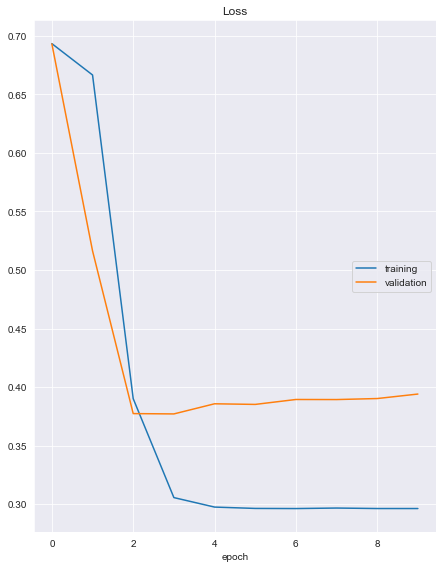

Loss
	training         	 (min:    0.296, max:    0.693, cur:    0.296)
	validation       	 (min:    0.377, max:    0.693, cur:    0.394)


In [7]:
# Fit method
nn_recommender = NNRecommender()
nn_recommender.fit(interactions_df, None, None)

In [8]:
# Recommender method

recommendations = nn_recommender.recommend(pd.DataFrame([[1], [2], [3], [4], [5]], columns=['user_id']), items_df, 10)

recommendations = pd.merge(recommendations, items_df, on='item_id', how='left')
display(HTML(recommendations.to_html()))

,user_id,item_id,score,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1,60,0.915797,OffSeason,[2-3],Nonref,[0-160],[2-2],True
1,1,93,0.863685,OffSeason,[2-3],Nonref,[160-260],[3-4],True
2,1,33,0.863398,OffSeason,[2-3],Standard,[0-160],[2-2],True
3,1,56,0.825607,OffSeason,[2-3],Nonref,[0-160],[3-4],True
4,1,6,0.782406,OffSeason,[2-3],Standard,[160-260],[5-inf],True
5,1,22,0.775219,OffSeason,[2-3],Standard,[0-160],[3-4],True
6,1,321,0.755876,HighSeason,[2-3],Nonref,[160-260],[2-2],True
7,1,67,0.736896,OffSeason,[4-7],Nonref,[0-160],[2-2],True
8,1,9,0.732046,HighSeason,[2-3],Standard,[260-360],[3-4],True
9,1,47,0.707784,WinterVacation,[2-3],Standard,[0-160],[2-2],True


# Tuning method

In [9]:
from evaluation_and_testing.testing import evaluate_train_test_split_implicit

seed = 6789

In [10]:
from hyperopt import hp, fmin, tpe, Trials
import traceback

def tune_recommender(recommender_class, interactions_df, items_df, 
                     param_space, max_evals=1, show_progressbar=True, seed=6789):
    # Split into train_validation and test sets

    shuffle = np.arange(len(interactions_df))
    rng = np.random.RandomState(seed=seed)
    rng.shuffle(shuffle)
    shuffle = list(shuffle)

    train_test_split = 0.8
    split_index = int(len(interactions_df) * train_test_split)

    train_validation = interactions_df.iloc[shuffle[:split_index]]
    test = interactions_df.iloc[shuffle[split_index:]]

    # Tune

    def loss(tuned_params):
        recommender = recommender_class(seed=seed, **tuned_params)
        hr1, hr3, hr5, hr10, ndcg1, ndcg3, ndcg5, ndcg10 = evaluate_train_test_split_implicit(
            recommender, train_validation, items_df, seed=seed)
        return -hr10

    n_tries = 1
    succeded = False
    try_id = 0
    while not succeded and try_id < n_tries:
        try:
            trials = Trials()
            best_param_set = fmin(loss, space=param_space, algo=tpe.suggest, 
                                  max_evals=max_evals, show_progressbar=show_progressbar, trials=trials, verbose=True)
            succeded = True
        except:
            traceback.print_exc()
            try_id += 1
            
    if not succeded:
        return None
        
    # Validate
    
    recommender = recommender_class(seed=seed, **best_param_set)

    results = [[recommender_class.__name__] + list(evaluate_train_test_split_implicit(
        recommender, {'train': train_validation, 'test': test}, items_df, seed=seed))]

    results = pd.DataFrame(results, 
                           columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

    display(HTML(results.to_html()))
    
    return best_param_set

## Tuning of the recommender

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Tune your model using the code below. You only need to put the class name of your recommender and choose an appropriate parameter space.

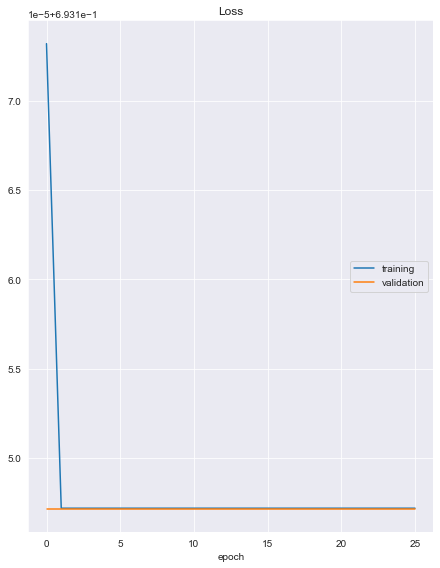

Loss
	training         	 (min:    0.693, max:    0.693, cur:    0.693)
	validation       	 (min:    0.693, max:    0.693, cur:    0.693)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.035981,0.090971,0.130686,0.183639,0.035981,0.067698,0.084163,0.101154


Best parameters:
{'batch_size': 1, 'embedding_dim': 14, 'lr': 0.043000000000000003, 'n_epochs': 26, 'n_neg_per_pos': 3, 'weight_decay': 0.0008}


In [11]:
param_space = {
    "n_neg_per_pos": hp.choice("n_neg_per_pos", np.arange(1, 11, dtype=int)),
    "embedding_dim": hp.choice("embedding_dim", np.arange(4, 65, 4, dtype=int)),
    "lr": hp.quniform("lr", 0.001, 0.1, 0.001),
    "weight_decay": hp.quniform("weight_decay", 0.0001, 0.01, 0.0001),
    "n_epochs": hp.choice("n_epochs", np.arange(10, 51, dtype=int)),
    "batch_size": hp.choice("batch_size", np.arange(16, 257, 16, dtype=int))
}

best_param_set = tune_recommender(NNRecommender, interactions_df, items_df,
                                  param_space, max_evals=200, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

# Final evaluation

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Run the final evaluation of your recommender and present its results against the Amazon and Netflix recommenders' results. You just need to give the class name of your recommender and its tuned parameters below.

It's optional, but for better effect you can include here the results from all recommenders created during in this class.

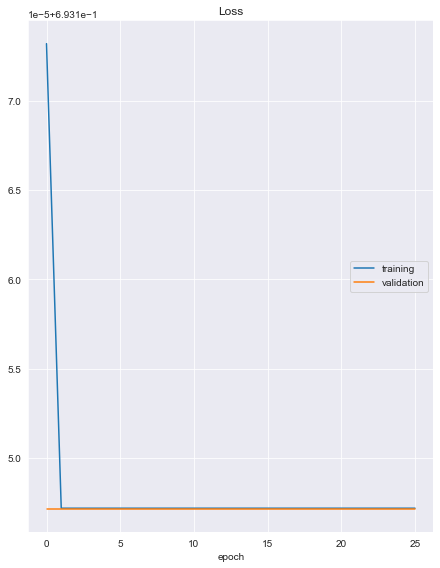

Loss
	training         	 (min:    0.693, max:    0.693, cur:    0.693)
	validation       	 (min:    0.693, max:    0.693, cur:    0.693)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.035981,0.090971,0.130686,0.183639,0.035981,0.067698,0.084163,0.101154


In [18]:
nn_recommender = NNRecommender(n_neg_per_pos=3, embedding_dim=14, lr=0.043, weight_decay=0.0008, n_epochs=26, batch_size=1)  # Initialize your recommender here

# Give the name of your recommender in the line below
nn_tts_results = [['NNRecommender'] + list(evaluate_train_test_split_implicit(
    nn_recommender, interactions_df, items_df))]

nn_tts_results = pd.DataFrame(
    nn_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(nn_tts_results.to_html()))

In [19]:
from recommenders.amazon_recommender import AmazonRecommender

amazon_recommender = AmazonRecommender()

amazon_tts_results = [['AmazonRecommender'] + list(evaluate_train_test_split_implicit(
    amazon_recommender, interactions_df, items_df))]

amazon_tts_results = pd.DataFrame(
    amazon_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(amazon_tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,AmazonRecommender,0.035981,0.09165,0.132043,0.185336,0.035981,0.068082,0.084824,0.102078


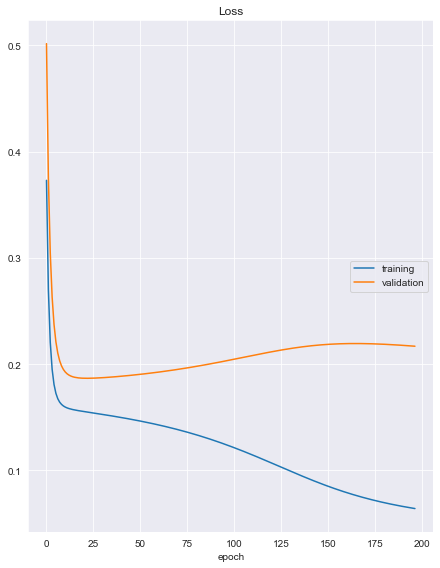

Loss
	training         	 (min:    0.064, max:    0.373, cur:    0.064)
	validation       	 (min:    0.187, max:    0.502, cur:    0.217)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NetflixRecommender,0.035981,0.092668,0.133741,0.187033,0.035981,0.06868,0.0857,0.102942


In [20]:
from recommenders.netflix_recommender import NetflixRecommender

netflix_recommender = NetflixRecommender(embedding_dim=8, n_epochs=200, print_type='live')

netflix_tts_results = [['NetflixRecommender'] + list(evaluate_train_test_split_implicit(
    netflix_recommender, interactions_df, items_df))]

netflix_tts_results = pd.DataFrame(
    netflix_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(netflix_tts_results.to_html()))

In [21]:
tts_results = pd.concat([nn_tts_results, amazon_tts_results, netflix_tts_results]).reset_index(drop=True)
display(HTML(tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.035981,0.090971,0.130686,0.183639,0.035981,0.067698,0.084163,0.101154
1,AmazonRecommender,0.035981,0.091650,0.132043,0.185336,0.035981,0.068082,0.084824,0.102078
2,NetflixRecommender,0.035981,0.092668,0.133741,0.187033,0.035981,0.068680,0.085700,0.102942


# Summary

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Write a summary of your experiments. What worked well and what did not? What are your thoughts how could you possibly further improve the model?

In [ ]:
# I got worse performance of recommender when using content based features, so I decided not to include these. The model could be improved by using neural network with different numbers of layers. neurons or activation functions. Also better results could be obtained by increasing time of tuning hyperparameters or changing range of tested values for each hyperparameter.